# COVID-19 Mortality Risk Prediction Using Machine Learning

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

## Data Loading

In [2]:
DATA_PATH = "../data/Covid19Data.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


## Initial Data Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

## Feature Engineering

### Removal of Potential Data Leakage Features

In [4]:
df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [5]:
df = df.drop(columns=['INTUBED', 'ICU'])
df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL'],
      dtype='object')

### Pregnancy Variable Preprocessing

In [6]:
df['PREGNANT'].value_counts()

PREGNANT
97    523511
2     513179
1       8131
98      3754
Name: count, dtype: int64

In [7]:
df[df['SEX'] == 1]['PREGNANT'].value_counts() #  1: Female

PREGNANT
2     513179
1       8131
98      3754
Name: count, dtype: int64

In [8]:
df[df['SEX'] == 2]['PREGNANT'].value_counts() #  2: Male

PREGNANT
97    523511
Name: count, dtype: int64

In [9]:
df['PREGNANT'] = df['PREGNANT'].replace([97, 98], 2)  # 1: pregnant, 2: not pregnant
df['PREGNANT'].value_counts()

PREGNANT
2    1040444
1       8131
Name: count, dtype: int64

### Filtering Uncertain and Invalid Values

In [10]:
df.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
DATE_DIED               401
PNEUMONIA                 3
AGE                     121
PREGNANT                  2
DIABETES                  3
COPD                      3
ASTHMA                    3
INMSUPR                   3
HIPERTENSION              3
OTHER_DISEASE             3
CARDIOVASCULAR            3
OBESITY                   3
RENAL_CHRONIC             3
TOBACCO                   3
CLASIFFICATION_FINAL      7
dtype: int64

In [11]:
binary_features = [
    'PNEUMONIA',
    'PREGNANT',
    'DIABETES',
    'COPD',
    'ASTHMA',
    'INMSUPR',
    'HIPERTENSION',
    'OTHER_DISEASE',
    'CARDIOVASCULAR',
    'OBESITY',
    'RENAL_CHRONIC',
    'TOBACCO',
]

mask = df[binary_features].isin([1, 2]).all(axis=1)
df = df[mask]
df.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
DATE_DIED               395
PNEUMONIA                 2
AGE                     121
PREGNANT                  2
DIABETES                  2
COPD                      2
ASTHMA                    2
INMSUPR                   2
HIPERTENSION              2
OTHER_DISEASE             2
CARDIOVASCULAR            2
OBESITY                   2
RENAL_CHRONIC             2
TOBACCO                   2
CLASIFFICATION_FINAL      7
dtype: int64

### Binary Feature Encoding

In [12]:
df[binary_features].apply(pd.Series.value_counts)

,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
2,887553,1017311,902737,1010776,994655,1011564,865575,998021,1005026,868191,1006801,942477
1,137599,7841,122415,14376,30497,13588,159577,27131,20126,156961,18351,82675


In [13]:
df[binary_features] = df[binary_features].replace(2, 0)

df[binary_features].apply(pd.Series.value_counts)

,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,887553,1017311,902737,1010776,994655,1011564,865575,998021,1005026,868191,1006801,942477
1,137599,7841,122415,14376,30497,13588,159577,27131,20126,156961,18351,82675


## Target Variable Construction

In [14]:
df['DATE_DIED'].value_counts()

DATE_DIED
9999-99-99    950438
06/07/2020       984
07/07/2020       981
13/07/2020       969
16/06/2020       965
               ...  
27/02/2021         1
26/02/2021         1
20/02/2021         1
11/02/2021         1
22/04/2021         1
Name: count, Length: 395, dtype: int64

In [15]:
df['IS_DEAD'] = (df['DATE_DIED'] != '9999-99-99').astype(int)  # 1: Deceased, 0: Alive
df = df.drop(columns=['DATE_DIED'])
df['IS_DEAD'].value_counts()

IS_DEAD
0    950438
1     74714
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

### Correlation Heatmap

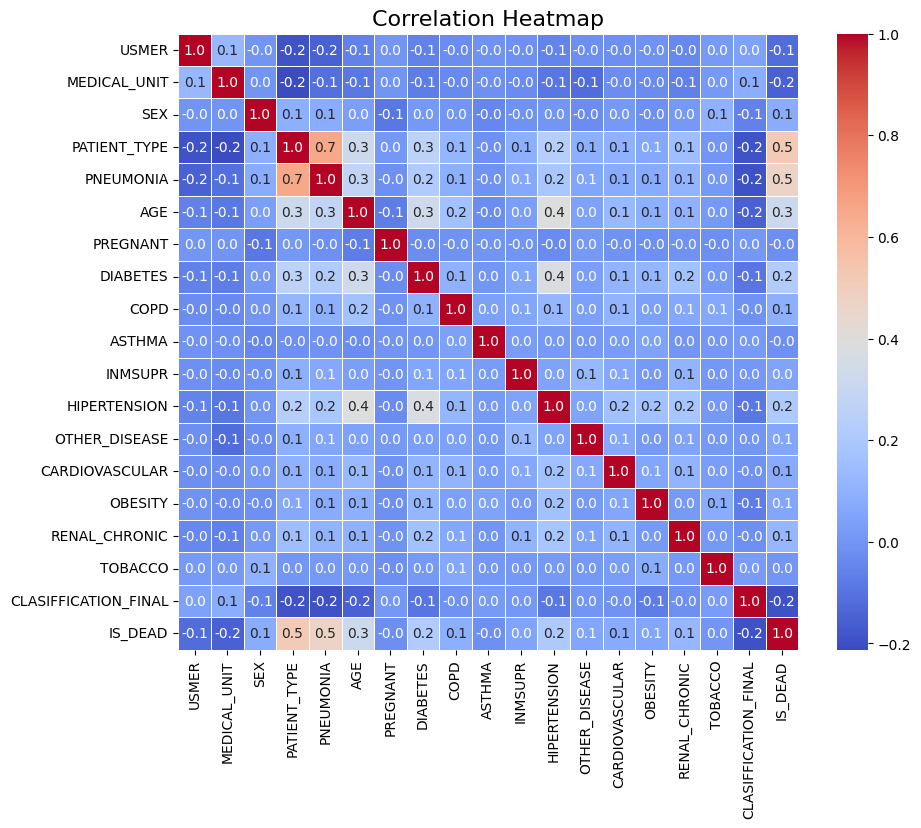

In [16]:
FIGURES_PATH = "../figures/"

plt.figure(figsize=(10, 8))
sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
)
plt.title('Correlation Heatmap', fontsize=16)
plt.savefig(f"{FIGURES_PATH}correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

### Age Distribution

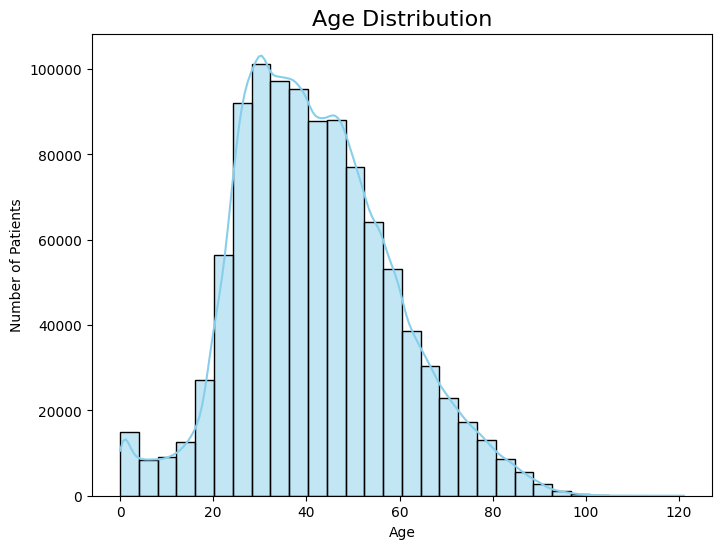

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(df['AGE'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.savefig(f"{FIGURES_PATH}age_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

## Data Preparation for Modeling

### Class Imbalance Analysis

In [18]:
df['IS_DEAD'].value_counts(normalize=True) * 100

IS_DEAD
0    92.71191
1     7.28809
Name: proportion, dtype: float64

### Feature–Target Correlation

In [19]:
death_corr = df.corr(numeric_only=True)['IS_DEAD'].drop('IS_DEAD')
death_corr[death_corr.abs() > 0.4]

PATIENT_TYPE    0.520023
PNEUMONIA       0.470800
Name: IS_DEAD, dtype: float64

### Feature–Target Split

In [20]:
X = df.drop(columns=['IS_DEAD'])
y = df['IS_DEAD']

print("Feature Matrix Shape:", X.shape)
print("Target Variable Shape:", y.shape)

Feature Matrix Shape: (1025152, 18)
Target Variable Shape: (1025152,)


### Train-Test Split

In [21]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (820121, 18)
X_test Shape: (205031, 18)
y_train Shape: (820121,)
y_test Shape: (205031,)


## Pipeline-Based Baseline Modeling (Logistic Regression)

In [ ]:
numeric_features = ['AGE']

categorical_features = [
    'USMER',
    'MEDICAL_UNIT',
    'SEX',
    'PATIENT_TYPE',
    'CLASIFFICATION_FINAL',
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features),
        ('cat', 'passthrough', categorical_features),
    ],
)

pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        (
            'classifier',
            LogisticRegression(
                max_iter=1000,
                class_weight='balanced',
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

pipeline.fit(X_train, y_train)

## Model Evaluation

### Classification Report

In [23]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    190088
           1       0.40      0.92      0.56     14943

    accuracy                           0.89    205031
   macro avg       0.70      0.91      0.75    205031
weighted avg       0.95      0.89      0.91    205031



### Confusion Matrix

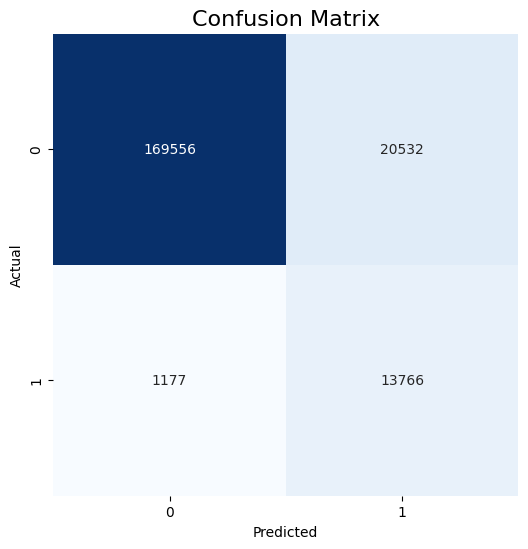

In [24]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f"{FIGURES_PATH}confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

### ROC-AUC Score

In [25]:
y_prob = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

ROC-AUC Score:
0.9544780536674718
